# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

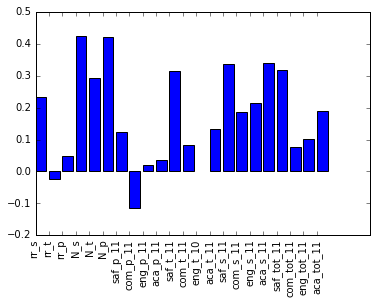

In [10]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

plt.bar(left=range(len(correlations.loc[survey_fields].index[1:])), height=correlations.loc[survey_fields].values[1:])
plt.xticks(range(len(correlations.loc[survey_fields].index[1:])), correlations.loc[survey_fields].index[1:], rotation='vertical')
plt.show()

com_p_11 - Communication score based on parent responses
aca_t_11 - Academic expectations score based on teacher responses

These two variables correlations seem strange.

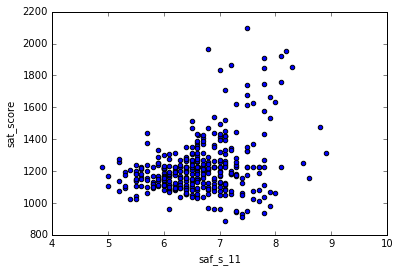

In [11]:
combined.plot.scatter(x="saf_s_11", y="sat_score")
plt.show()

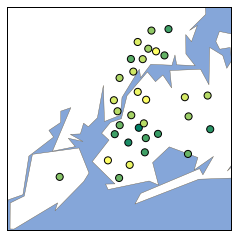

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

avg_score_by_district = pd.pivot_table(data=combined, index="school_dist", aggfunc=np.mean)
avg_score_by_district.reset_index(inplace=True)

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = avg_score_by_district["lon"].tolist()
latitudes = avg_score_by_district["lat"].tolist()
m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=avg_score_by_district["saf_s_11"], cmap="summer")
plt.show()

Visually there seems to be positive correlation between preceived safety by students and sat_scores, although it is not strong. Parts of Brooklyn, Queens and Manhatten have the highest average safety score preceived by students, whilst other parts of Queens and Brooklyn as well as parts of the Bronx have the lowest safety scores preceived by students.

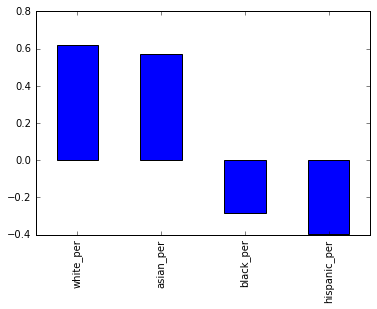

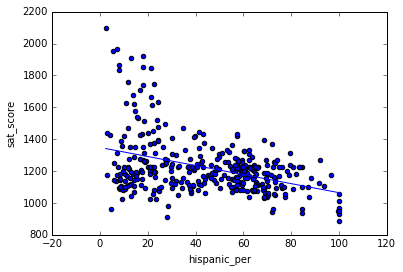

In [13]:
racial_columns = ["white_per","asian_per","black_per","hispanic_per"]

correlations[racial_columns].plot.bar()

fig = plt.figure()
ax = fig.add_subplot()

combined.plot.scatter(x="hispanic_per", y="sat_score",ax=ax)

x = combined["hispanic_per"].values
y = combined["sat_score"].values

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))

plt.show()



There appears to be positive correlation between white_per and sat_score also asian_per and sat_score.

There appears to be negative correlation between black_per and sat_score also hispanic_per and sat_score.

In [14]:
combined[combined["hispanic_per"]>95]["SCHOOL NAME"]

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In [15]:
combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]["SCHOOL NAME"]

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools with a very high proportion of Hispanic students appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students that English is a second language, which would explain the lower SAT scores.

Many of the schools with a very low proportion of Hispanic students and very high SAT scores are specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

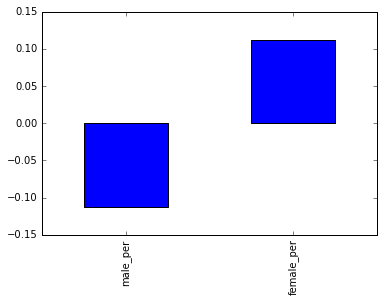

In [16]:
gender_per = ["male_per","female_per"]
correlations[gender_per].plot.bar()
plt.show()

According to the graph above a higher percentage of male students within a school correlates mildly negatively with SAT scores. Conversely a higher percentage of female students within a school correlates mildly positively with SAT scores.

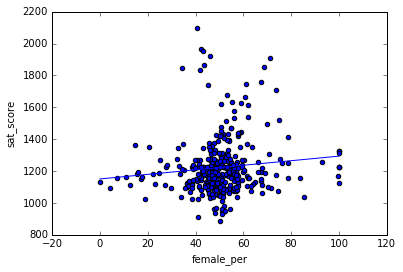

In [17]:
combined.plot.scatter(x="female_per",y="sat_score")
x = combined["female_per"]
y = combined["sat_score"]
plt.plot(np.unique(x),np.poly1d(np.polyfit(x,y,1))(np.unique(x)))

The schools with the highest SAT scores have somewhere between 30 and 70% females, whilst schools having less than or higher than this percentage tend to have lower SAT scores. This could be because being in an environment with a more balanced proportion in the genders fosters learning. Previous inference was a stretch.

In [18]:
combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]["SCHOOL NAME"]

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of the schools with a high proportion of female students and high SAT scores are selective college prepartory schools, therefore they are only for highly motivated, gifted students. This would explain the high SAT scores since students would necessarily have to be highly intelligent to get a place at these schools thus driving up average SAT scores. However, it doesn't explain why the students at the these schools are typically girls

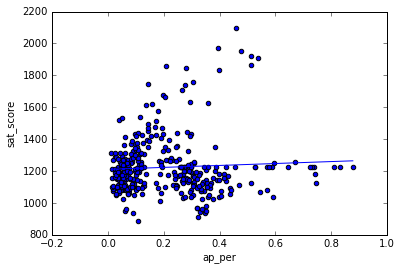

In [19]:
combined["ap_per"] = combined["AP Test Takers "]/combined["total_enrollment"]

x = combined["ap_per"]
y = combined["sat_score"]

combined.plot.scatter(x="ap_per",y="sat_score")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x,y,1))(np.unique(x)))

Although there are a few schools with a high advanced placement percentage and also a high SAT score, there doesn't seems to be much of a relationship between Advanced Placement percentage and SAT scores.

AVERAGE CLASS SIZE                0.381014
SIZE OF SMALLEST CLASS            0.249949
SIZE OF LARGEST CLASS             0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO         NaN
Name: sat_score, dtype: float64

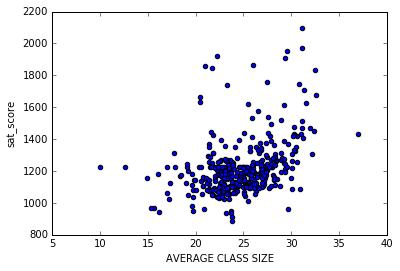

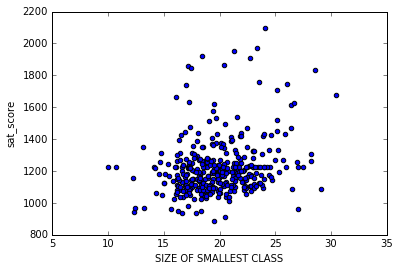

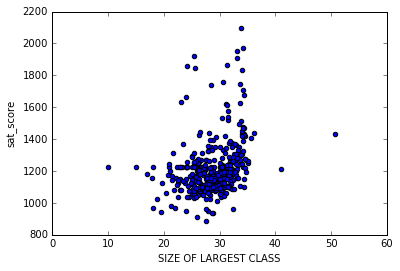

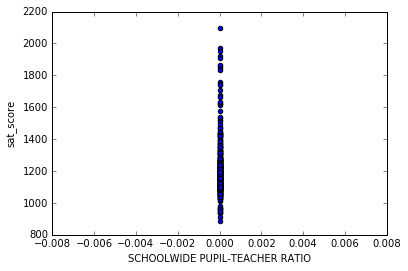

In [26]:
combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score")
combined.plot.scatter(x="SIZE OF SMALLEST CLASS", y="sat_score")
combined.plot.scatter(x="SIZE OF LARGEST CLASS", y="sat_score")
combined.plot.scatter(x="SCHOOLWIDE PUPIL-TEACHER RATIO", y="sat_score")

correlations[["AVERAGE CLASS SIZE","SIZE OF SMALLEST CLASS","SIZE OF LARGEST CLASS","SCHOOLWIDE PUPIL-TEACHER RATIO"]]

In [23]:
print(combined.columns.values)

['DBN' 'SCHOOL NAME' 'Num of SAT Test Takers'
 'SAT Critical Reading Avg. Score' 'SAT Math Avg. Score'
 'SAT Writing Avg. Score' 'sat_score' 'SchoolName' 'AP Test Takers '
 'Total Exams Taken' 'Number of Exams with scores 3 4 or 5' 'Demographic'
 'School Name' 'Cohort' 'Total Cohort' 'Total Grads - n'
 'Total Grads - % of cohort' 'Total Regents - n'
 'Total Regents - % of cohort' 'Total Regents - % of grads'
 'Advanced Regents - n' 'Advanced Regents - % of cohort'
 'Advanced Regents - % of grads' 'Regents w/o Advanced - n'
 'Regents w/o Advanced - % of cohort' 'Regents w/o Advanced - % of grads'
 'Local - n' 'Local - % of cohort' 'Local - % of grads'
 'Still Enrolled - n' 'Still Enrolled - % of cohort' 'Dropped Out - n'
 'Dropped Out - % of cohort' 'CSD' 'NUMBER OF STUDENTS / SEATS FILLED'
 'NUMBER OF SECTIONS' 'AVERAGE CLASS SIZE' 'SIZE OF SMALLEST CLASS'
 'SIZE OF LARGEST CLASS' 'SCHOOLWIDE PUPIL-TEACHER RATIO' 'Name'
 'schoolyear' 'fl_percent' 'frl_percent' 'total_enrollment' 'prek'

In [27]:
combined["Demographic"].head(10)

0    Total Cohort
1    Total Cohort
2    Total Cohort
3    Total Cohort
4    Total Cohort
5    Total Cohort
6    Total Cohort
7    Total Cohort
8    Total Cohort
9    Total Cohort
Name: Demographic, dtype: object